# Setup

## Download the repo

In [2]:
# !git clone https://github.com/YuanGongND/ssast.git
!git clone https://github.com/roeizig/ssast.git

Cloning into 'ssast'...
remote: Enumerating objects: 7849, done.
remote: Counting objects: 100% (293/293), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 7849 (delta 144), reused 280 (delta 135), pack-reused 7556
Receiving objects: 100% (7849/7849), 846.82 MiB | 23.80 MiB/s, done.
Resolving deltas: 100% (639/639), done.
Checking out files: 100% (8725/8725), done.


## Install requirements

In [3]:
!cd ssast/
!pip install -r /content/ssast/requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [5]:
import torch
import torchaudio
from PIL import Image
import numpy as np
from ssast.src.models.ast_models import *
from tqdm.notebook import tqdm_notebook
import time
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import output
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import RawScoresOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from google.colab.patches import cv2_imshow

output.enable_custom_widget_manager()

# output.disable_custom_widget_manager()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Overriding the model

## New model definition

In [6]:
from ssast.src.models.ast_models import ASTModel

class ASTModelRoei(ASTModel):
    def __init__(self):
      super().__init__(fshape=16, tshape=16, fstride=10, tstride=10, 
                      input_fdim=128, input_tdim=1024, model_size='tiny', 
                      pretrain_stage=False, load_pretrained_mdl_path='/content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth')
      # regressor head for fine-tuning / inference
      # self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
      #                               nn.Linear(self.original_embedding_dim, 1))
      self.regressor_head = nn.Sequential(nn.LayerNorm(self.original_embedding_dim),
                                    nn.Linear(self.original_embedding_dim, 1))


    def finetuning_regressor(self, x, y, loss_method = 'L1'):
        # Finetuning using the regressor task.
        # Calculate MSE loss and update weights accordingly
        # B = x.shape[0]

        # Calculate RMSE loss and update weights
        pred = self.regressor(x)
        target = y
        # If cannot use reference in a vectorized manner, use the for loop below
        # pred = torch.empty((B), device=x.device).float()  # e.g. size 12 for a batch of 12 spectrograms
        # target = torch.empty((B), device=x.device).float() # e.g. size 12 for a batch of 12 spectrograms
        # for i in range(B):
        #     #  +2 for indexes because of cls and dis token
        #     pred[i] = self.regressor(x[i])
        #     target[i] = y[i]
        # calculate the RMSE loss
        # rmse = torch.mean((pred - target) ** 2)**0.5

        # Update weights according to MSE loss
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        optimizer.zero_grad()
        criterion = nn.MSELoss() if loss_method == 'L2' else nn.L1Loss()
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        return loss


    def regressor(self, x):
        # Copied from "finetuningavgtok"
        # changed only the last part, sending the intermediate result
        # to the regressor head instead of the mlp head.
        # Inference only mode
        B = x.shape[0]
        x = self.v.patch_embed(x)
        if self.cls_token_num == 2:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            dist_token = self.v.dist_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, dist_token, x), dim=1)
        else:
            cls_tokens = self.v.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.v.pos_embed
        x = self.v.pos_drop(x)

        for blk_id, blk in enumerate(self.v.blocks):
            x = blk(x)
        x = self.v.norm(x)

        # average output of all tokens except cls token(s)
        x = torch.mean(x[:, self.cls_token_num:, :], dim=1)
        x = self.regressor_head(x)
        return x


    def forward(self, x, task = 'regressor', y=None, cluster=True, mask_patch=400, loss_method = 'L1'):
        # expect input x = (batch_size, time_frame_num, frequency_bins), e.g., (12, 1024, 128)
        x = x.unsqueeze(1)
        x = x.transpose(2, 3)

        # finetuning (ft), use the mean of all token (patch) output as clip-level representation.
        # this is default for SSAST fine-tuning as during pretraining, supervision signal is given to each token, not the [cls] token
        if task == 'ft_avgtok':
            return self.finetuningavgtok(x)
        # fine tuning the model as a regressor
        elif task == 'ft_regressor':
            return self.finetuning_regressor(x, y, loss_method)
        # inference using a regressor
        elif task == 'regressor':
            return self.regressor(x)
        # alternatively, use the [cls] token output as clip-level representation.
        elif task == 'ft_cls':
            return self.finetuningcls(x)
        # pretraining, masked patch classification (discriminative objective)
        elif task == 'pretrain_mpc':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster)
        # pretraining, masked patch reconstruction (generative objective)
        elif task == 'pretrain_mpg':
            return self.mpg(x, mask_patch=mask_patch, cluster=cluster)
        elif task == 'visualize_mask':
            return self.mpc(x, mask_patch=mask_patch, cluster=cluster, show_mask=True)
        else:
            raise Exception('Task unrecognized.')



## Creating the overridden model

In [7]:
# new_model = ASTModelRoei()
# new_model.eval()
# new_model.to(device)

## Creating the dataset

In [8]:
## Creating Dataset
from random import sample
from torch.utils.data import Dataset, DataLoader
import os
import math
from torchvision import transforms


class SpectrogramData(Dataset):
    
    def __init__(self, audio_dir, device):
        self.audio_dir = audio_dir
        self.device = device
        self._create_ann()
        self.transform = transforms.PILToTensor()

        
    def __len__(self):
        return len(self.annotations[0])
        

    def __getitem__(self, index):
        sample_path = self._get_sample_path(index)
        label = float(self._get_sample_label(index))

        signal = Image.open(sample_path)
        signal = self.transform(signal)
        signal = signal.to(self.device, dtype=torch.float)
        return signal, label, index

            
    def _create_ann(self, path="ssast/spectrogram_images_V3a/"):
        Ann = [[],[],[]]
        for subdir, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('png'):
                                Ann[0].append(file) ##name
                                Ann[1].append(subdir) #folder
                                tmp_label = file.split('_')[-1]
                                Ann[2].append(float(tmp_label[:-4])) #label
        Ann = np.asarray(Ann)
        self.annotations = Ann


    def shuffle(self):
      perm = torch.randperm(len(self.annotations[0]))
      self.annotations= self.annotations[:,perm]
      pass    
    

    def _get_sample_path(self, index):
        folder = self.annotations[1][index]
        filename = self.annotations[0][index]
        path = os.path.join(self.audio_dir, folder, filename)
        return path
    

    def _get_sample_label(self, index):
        label = self.annotations[2][index]
        return label

##Functuins for DataViz
    def _index_from_label(self, query_label):
        labels =[float(x) for x in self.annotations[2]]
        query_label = np.asarray(query_label)
        diff = (np.abs(labels-query_label))
        # index = diff.argmin()
        index = np.where(diff == diff.min())
        # print(np.where(diff == diff.min()))
        # print(index)
        return index
        
    def seq_from_label(self, query, query_type = 'label'):
        
        if query_type == 'label':
          index = self._index_from_label(query)
          # print(index[0][0])
          index = index[0][0]
        else:
          index = query
        folder = self.annotations[1][index]
        current_call_filename = self.annotations[0][index]
        
        current_call_path = self._get_sample_path(index)
        current_call =Image.open(current_call_path)
        
        current_call_num = int(current_call_filename.split('_')[-3])
        prefix = '_'.join(current_call_filename.split('_')[:-3])

        next_call_prefix = '_'.join([prefix, str(current_call_num+1)])+'_'
        prev_call_prefix = '_'.join([prefix, str(current_call_num-1)])+'_'
        
      
        next_call_filename= None
        prev_call_filename = None
        next_call = None
        prev_call = None
      
        for subdir, dirs, files in os.walk(folder):
          for file in files:
              if file.startswith(bytes(next_call_prefix,'utf-8')):
                              next_call_filename = file.decode()
                              next_call_path = os.path.join(folder, next_call_filename)
                              next_call = Image.open(next_call_path)
              if file.startswith(bytes(prev_call_prefix,'utf-8')):
                              prev_call_filename = file.decode()
                              prev_call_path = os.path.join(folder, prev_call_filename)
                              prev_call = Image.open(prev_call_path)
        
        images = [prev_call, current_call, next_call]
        names  = [prev_call_filename, current_call_filename, next_call_filename]

        for i, (img,name) in enumerate(zip(images, names)):
          if img:
            img = img.transpose(Image.FLIP_TOP_BOTTOM)
            plt.imshow(img, origin = 'lower')
            plt.title(name)
            plt.show()
          else:
            if i == 0:
              print(f'previous call does not exist')
            else:
              print(f'next call does not exist')

        return images, names




In [9]:
path = "ssast/spectrogram_images_V3a/"
x = SpectrogramData("", device)
print(len(x))
trainval , testset = torch.utils.data.random_split(x, [1900, len(x)-1900],
                                            generator=torch.Generator().manual_seed(42))
trainset, valset = torch.utils.data.random_split(trainval, [1500, 400],
                                                generator=torch.Generator().manual_seed(42))

2034


In [8]:
# ##Testing the sequence display
# label = 52.2493
# # label = 60
# images, names = x.seq_from_label(label)

## Testing the model on a single spectrogram

In [ ]:
# xx = x[1]
# pred = new_model(xx[0], task='regressor')
# label = xx[-1]
# print(pred)
# print(label)

In [ ]:
# new_model(spectgram.unsqueeze(0).to(dtype=torch.float), task='ft_regressor', y=torch.Tensor([[float(xx[-1])]]))

# Training the Model

In [13]:
batch_size = 16
trainloader = DataLoader(trainset, batch_size=batch_size,
                            shuffle=True, num_workers=0)
valloader = DataLoader(valset, batch_size=batch_size,
                        shuffle=True, num_workers=0)


In [ ]:
# torch.cuda.empty_cache()

In [14]:
def train_loop(trainloader, valloader, model, epochs = 30, loss_method = 'L2'):
  model = model.to(device)
  train_losses, val_losses = [], []
  train_accs, val_accs = [], []
  for e in range(epochs):
      running_loss = 0
      train_correct = 0
      model.train()
      for images, labels,_ in tqdm_notebook(trainloader):

          images = images.to(device, dtype=torch.float)
          labels = labels.to(device, dtype=torch.float)
          loss = model(images.squeeze(1), task='ft_regressor', y=labels.unsqueeze(-1), loss_method = loss_method)
          loss = loss.item()
          
          # print(loss)
          running_loss += loss
          # ##evaluating without dropout
          # with torch.no_grad():
          #   model.eval()
          #   logits = model(images.to(device))
          #   ps = torch.softmax(logits,dim=1)
          #   top_ps, top_class = ps.topk(1,dim=1)
          #   train_equals_batch = top_class == (labels.view(*top_class.shape))
          #   train_correct +=train_equals_batch.sum().item()
          
          # model.train()
          
          
      else:
          running_val_loss = 0
          val_correct = 0
          
          with torch.no_grad():
              model.eval()
              for images, labels,_ in tqdm_notebook(valloader):  
                  images = images.to(device, dtype=torch.float)
                  labels = labels.to(device, dtype=torch.float)
                  pred = model(images.squeeze(1), task='regressor', y=labels.unsqueeze(-1), loss_method = loss_method)
                  criterion = nn.MSELoss() if loss_method == 'L2' else nn.L1Loss()
                  loss = criterion(pred, labels.unsqueeze(-1).to(device, dtype = float))
                  loss = loss.item()
                  running_val_loss += loss

                  # ps = torch.softmax(logits, dim=1)
                  # top_ps, top_class = ps.topk(1,dim=1)
                  # equals_batch = top_class == labels.view(*top_class.shape)
                  # test_correct +=equals_batch.sum().item()
              model.train()
          
          training_loss = running_loss/len(trainloader)
          val_loss = running_val_loss/len(valloader)
          train_accuracy = 0 # train_correct/len(trainloader.dataset)
          val_accuracy = 0 #test_correct/len(testloader.dataset)
          if e>0:
            if val_loss<min(val_losses):
              print('saving model...')
              torch.save(model.state_dict(),'model.pth')

          
          train_losses.append(training_loss)
          val_losses.append(val_loss)
          train_accs.append(train_accuracy)
          val_accs.append(val_accuracy)
          print("Epoch: {}/{}.. ".format(e+1, epochs),
                "Training Loss: {:.3f}.. ".format(training_loss),
                "Test Loss: {:.3f}.. ".format(val_loss))
  return train_losses, train_accs, val_losses, val_accs  

In [16]:
new_model = ASTModelRoei()
new_model.to(device)
trainloss,trainacc,valloss,valacc = train_loop(trainloader, valloader, model = new_model, epochs = 100, loss_method = 'L2')


now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1/100..  Training Loss: 1305.315..  Test Loss: 583.413.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 2/100..  Training Loss: 186.219..  Test Loss: 15.987.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3/100..  Training Loss: 16.065..  Test Loss: 18.521.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4/100..  Training Loss: 12.159..  Test Loss: 19.828.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 5/100..  Training Loss: 10.831..  Test Loss: 8.126.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6/100..  Training Loss: 8.693..  Test Loss: 8.523.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 7/100..  Training Loss: 7.880..  Test Loss: 5.611.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8/100..  Training Loss: 7.367..  Test Loss: 7.151.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9/100..  Training Loss: 6.481..  Test Loss: 8.246.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10/100..  Training Loss: 6.285..  Test Loss: 8.135.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11/100..  Training Loss: 6.357..  Test Loss: 6.963.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12/100..  Training Loss: 6.321..  Test Loss: 8.660.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13/100..  Training Loss: 5.943..  Test Loss: 6.252.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 14/100..  Training Loss: 5.674..  Test Loss: 5.000.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15/100..  Training Loss: 5.957..  Test Loss: 5.335.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 16/100..  Training Loss: 5.390..  Test Loss: 4.559.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17/100..  Training Loss: 5.398..  Test Loss: 7.215.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18/100..  Training Loss: 5.246..  Test Loss: 5.139.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19/100..  Training Loss: 5.632..  Test Loss: 7.350.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 20/100..  Training Loss: 5.547..  Test Loss: 4.499.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 21/100..  Training Loss: 4.968..  Test Loss: 8.139.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 22/100..  Training Loss: 5.086..  Test Loss: 9.866.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 23/100..  Training Loss: 4.851..  Test Loss: 6.499.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 24/100..  Training Loss: 4.374..  Test Loss: 4.490.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 25/100..  Training Loss: 4.328..  Test Loss: 4.652.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 26/100..  Training Loss: 4.506..  Test Loss: 5.152.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 27/100..  Training Loss: 4.152..  Test Loss: 5.304.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 28/100..  Training Loss: 4.240..  Test Loss: 4.094.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 29/100..  Training Loss: 3.927..  Test Loss: 4.839.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 30/100..  Training Loss: 4.025..  Test Loss: 3.607.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 31/100..  Training Loss: 4.099..  Test Loss: 6.427.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 32/100..  Training Loss: 4.227..  Test Loss: 5.117.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 33/100..  Training Loss: 3.748..  Test Loss: 4.598.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 34/100..  Training Loss: 4.028..  Test Loss: 8.488.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 35/100..  Training Loss: 4.201..  Test Loss: 7.978.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 36/100..  Training Loss: 3.732..  Test Loss: 4.448.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 37/100..  Training Loss: 3.757..  Test Loss: 3.741.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 38/100..  Training Loss: 3.362..  Test Loss: 3.991.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 39/100..  Training Loss: 3.434..  Test Loss: 4.956.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 40/100..  Training Loss: 3.395..  Test Loss: 4.926.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 41/100..  Training Loss: 3.364..  Test Loss: 3.820.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 42/100..  Training Loss: 3.271..  Test Loss: 4.202.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 43/100..  Training Loss: 3.805..  Test Loss: 3.968.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 44/100..  Training Loss: 3.705..  Test Loss: 5.107.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 45/100..  Training Loss: 3.558..  Test Loss: 4.060.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 46/100..  Training Loss: 3.455..  Test Loss: 5.978.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 47/100..  Training Loss: 3.527..  Test Loss: 4.177.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 48/100..  Training Loss: 4.066..  Test Loss: 4.536.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 49/100..  Training Loss: 3.583..  Test Loss: 3.498.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 50/100..  Training Loss: 3.344..  Test Loss: 5.373.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 51/100..  Training Loss: 3.192..  Test Loss: 5.212.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 52/100..  Training Loss: 3.202..  Test Loss: 4.238.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 53/100..  Training Loss: 3.495..  Test Loss: 6.577.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 54/100..  Training Loss: 3.173..  Test Loss: 3.970.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 55/100..  Training Loss: 3.168..  Test Loss: 3.461.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 56/100..  Training Loss: 3.157..  Test Loss: 3.782.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 57/100..  Training Loss: 3.071..  Test Loss: 3.958.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 58/100..  Training Loss: 3.169..  Test Loss: 4.238.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 59/100..  Training Loss: 3.201..  Test Loss: 4.030.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 60/100..  Training Loss: 2.913..  Test Loss: 4.709.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 61/100..  Training Loss: 2.976..  Test Loss: 3.833.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 62/100..  Training Loss: 2.909..  Test Loss: 4.627.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 63/100..  Training Loss: 2.762..  Test Loss: 3.548.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 64/100..  Training Loss: 2.850..  Test Loss: 4.069.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 65/100..  Training Loss: 2.778..  Test Loss: 3.524.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 66/100..  Training Loss: 2.583..  Test Loss: 3.474.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 67/100..  Training Loss: 2.877..  Test Loss: 3.717.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 68/100..  Training Loss: 2.586..  Test Loss: 4.600.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 69/100..  Training Loss: 2.583..  Test Loss: 4.974.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 70/100..  Training Loss: 2.626..  Test Loss: 4.106.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 71/100..  Training Loss: 2.787..  Test Loss: 5.135.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 72/100..  Training Loss: 2.709..  Test Loss: 3.267.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 73/100..  Training Loss: 2.823..  Test Loss: 3.626.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 74/100..  Training Loss: 2.587..  Test Loss: 4.631.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 75/100..  Training Loss: 2.577..  Test Loss: 4.178.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 76/100..  Training Loss: 2.412..  Test Loss: 4.017.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 77/100..  Training Loss: 2.662..  Test Loss: 3.588.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 78/100..  Training Loss: 2.243..  Test Loss: 4.081.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

saving model...
Epoch: 79/100..  Training Loss: 2.300..  Test Loss: 3.162.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 80/100..  Training Loss: 2.239..  Test Loss: 3.855.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 81/100..  Training Loss: 2.329..  Test Loss: 3.548.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 82/100..  Training Loss: 2.302..  Test Loss: 3.339.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 83/100..  Training Loss: 2.235..  Test Loss: 3.863.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 84/100..  Training Loss: 2.263..  Test Loss: 4.133.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 85/100..  Training Loss: 2.292..  Test Loss: 4.148.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 86/100..  Training Loss: 2.281..  Test Loss: 3.246.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 87/100..  Training Loss: 2.302..  Test Loss: 3.951.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 88/100..  Training Loss: 2.208..  Test Loss: 3.413.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 89/100..  Training Loss: 2.312..  Test Loss: 3.208.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 90/100..  Training Loss: 2.030..  Test Loss: 4.008.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 91/100..  Training Loss: 2.094..  Test Loss: 4.268.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 92/100..  Training Loss: 2.186..  Test Loss: 4.182.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 93/100..  Training Loss: 2.078..  Test Loss: 3.899.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 94/100..  Training Loss: 2.744..  Test Loss: 5.492.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 95/100..  Training Loss: 2.088..  Test Loss: 3.840.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 96/100..  Training Loss: 1.947..  Test Loss: 3.364.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 97/100..  Training Loss: 2.151..  Test Loss: 3.268.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 98/100..  Training Loss: 2.091..  Test Loss: 3.718.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 99/100..  Training Loss: 2.195..  Test Loss: 3.982.. 


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 100/100..  Training Loss: 2.082..  Test Loss: 3.667.. 


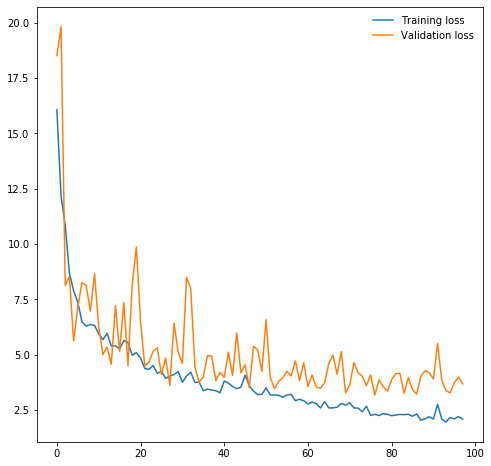

In [17]:
plt.figure(figsize = (8,8))
plt.plot(trainloss[2:],label = 'Training loss')
plt.plot(valloss[2:],label = 'Validation loss')
plt.legend(frameon=False)


In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

In [ ]:
# Save the model itself
# torch.save(new_model, 'model_30e_clean.pth')

# Save the model's weights
torch.save(new_model.state_dict(), 'model_weights_100e_V3.pth')

In [ ]:
# plt.figure(figsize = (8,8))
# plt.plot(trainloss,label = 'Training loss')
# plt.plot(valloss,label = 'Validation loss')
# plt.legend(frameon=False)

# # plt.figure(figsize = (8,8))
# # plt.plot(train_accs_d,label = 'Training Accuracy')
# # plt.plot(test_accs_d,label = 'Validation Accuracy')
# # plt.legend(frameon=False)

# Load an existing model

In [14]:
new_model = ASTModelRoei()
new_model.load_state_dict(torch.load('/content/ssast/pretrained_model/model_weights_79e_L2_early_stop_super_clean_data.pth'))
# new_model.load_state_dict(torch.load('model.pth'))
new_model.eval()
new_model.to(device)

now load a SSL pretrained models from /content/ssast/pretrained_model/SSAST-Tiny-Patch-400.pth
pretraining patch split stride: frequency=16, time=16
pretraining patch shape: frequency=16, time=16
pretraining patch array dimension: frequency=8, time=64
pretraining number of patches=512
fine-tuning patch split stride: frequncey=10, time=10
fine-tuning number of patches=1212


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


ASTModelRoei(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 192, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=768, out_features=192, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((19

# Analyze results

## Functions

In [11]:
def get_sample_results(model, dataset):
    data_size = len(dataset.indices)
    if data_size < 256:
        dataloader = DataLoader(dataset, batch_size=data_size,
                                shuffle=True, num_workers=0)
        images, labels, index = next(iter(dataloader))
        with torch.no_grad():
            model.eval()
            preds = model(images.squeeze(1).to(device, dtype=torch.float), task='regressor')
            diff = preds.squeeze().cpu() - labels.squeeze().cpu()
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    else:
        batch_size = 256
        dataloader = DataLoader(dataset, batch_size=batch_size,
                                shuffle=True, num_workers=0)
        labels = torch.tensor((), device=device)
        preds = torch.tensor((), device=device)
        diff = torch.tensor(())
        index = torch.tensor(())
        with torch.no_grad():
            model.eval()
            for batch_images, batch_labels, batch_index in dataloader:
                batch_images = batch_images.to(device, dtype=torch.float)
                batch_labels = batch_labels.to(device, dtype=torch.float)
                batch_preds = model(batch_images.squeeze(1), task='regressor')
                batch_diff = batch_preds.squeeze().cpu() - batch_labels.squeeze().cpu()
                labels = torch.cat([labels, batch_labels], dim=0)
                preds = torch.cat([preds, batch_preds], dim=0)
                diff = torch.cat([diff, batch_diff], dim=0)
                index = torch.cat([index, batch_index], dim=0)
            rmse = torch.sqrt(torch.mean(torch.square(diff)))
    print(f"Dataset RMSE is {rmse:.2f}")
    return pd.DataFrame({'pred': preds.cpu().squeeze(), 
                         'label': labels.cpu().squeeze(), 
                         'diff' :diff, 
                         'abs_diff': diff.abs(),
                         'index' : index})

In [12]:
def analyze_sample_results(stats_df):
    # Scatter plot with linear trend y=x
    lin_min = np.min([stats_df['pred'].min(), stats_df['label'].min()])
    lin_max = np.max([stats_df['pred'].max(), stats_df['label'].max()])
    plt.figure(figsize=(15, 9))
    plt.scatter(stats_df['label'], stats_df['pred'])
    plt.plot([lin_min, lin_max], [lin_min, lin_max], color='red')
    plt.title("Model prediction vs. label", size=18)
    plt.xlabel("Label", size=16)
    plt.ylabel("Prediction", size=16)
    plt.show()

    # Error histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['diff'], bins=100)
    plt.title("Model's error distribution", size=18)
    plt.xlabel("Error", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()


    # label histogram
    plt.figure(figsize=(15, 9))
    plt.hist(stats_df['label'], bins=100)
    plt.title("GT distribution", size=18)
    plt.xlabel("label", size=16)
    plt.ylabel("Amount", size=16)
    plt.show()

    # Diff statistics
    display(stats_df.describe([.1, .25, .5, .75, .9])[['abs_diff']].T)

## Test analysis

Dataset RMSE is 1.85


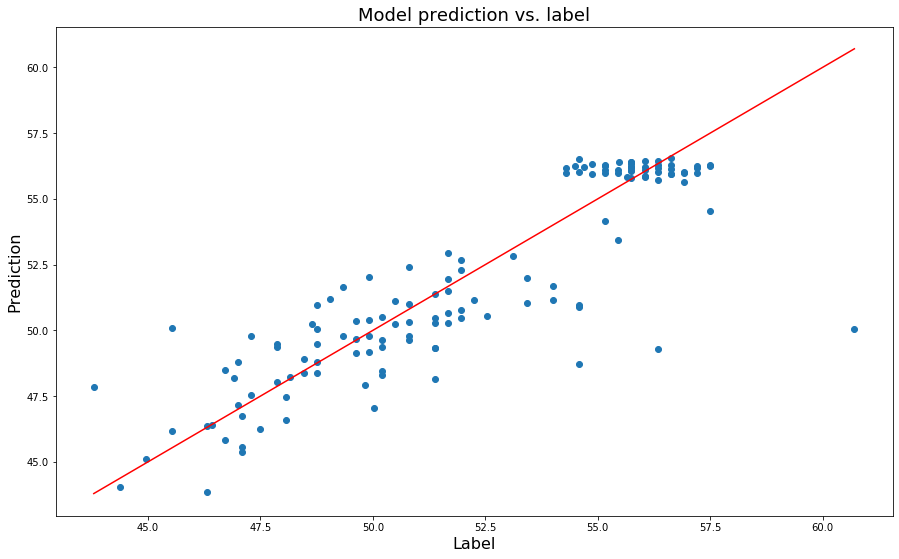

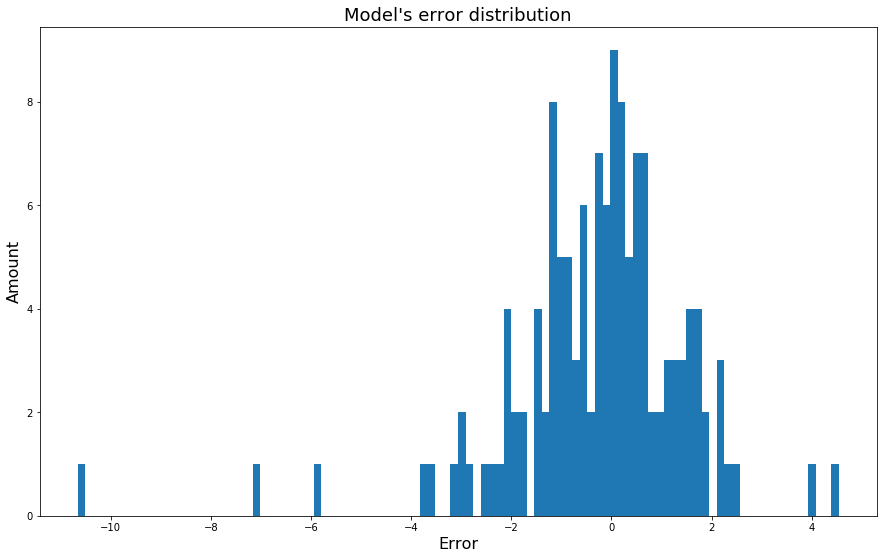

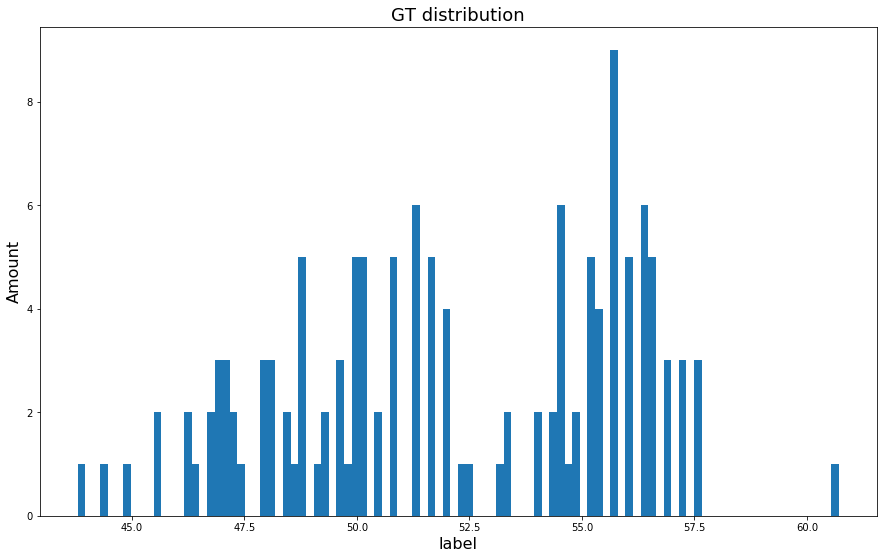

count      mean       std       min       10%       25%      50%  \
abs_diff  134.0  1.231675  1.386584  0.017803  0.159472  0.344192  0.91673   

               75%       90%       max  
abs_diff  1.611212  2.361685  10.65787

In [21]:
test_df = get_sample_results(new_model, testset)
analyze_sample_results(test_df)
torch.cuda.empty_cache()

## Train & Validation analysis

Dataset RMSE is 1.40


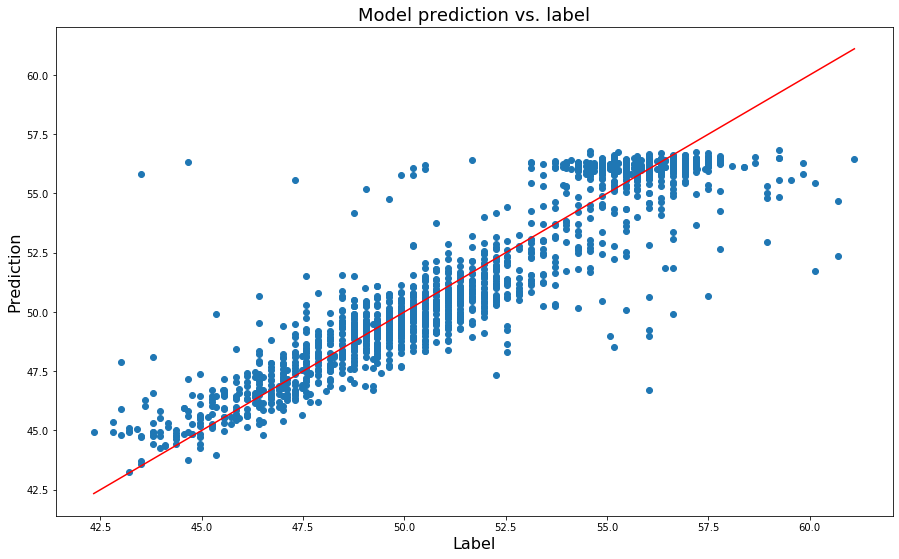

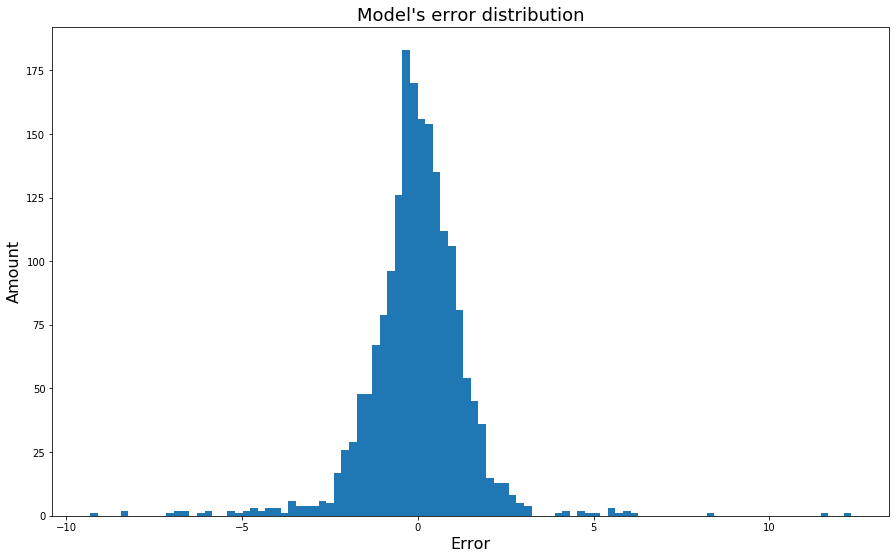

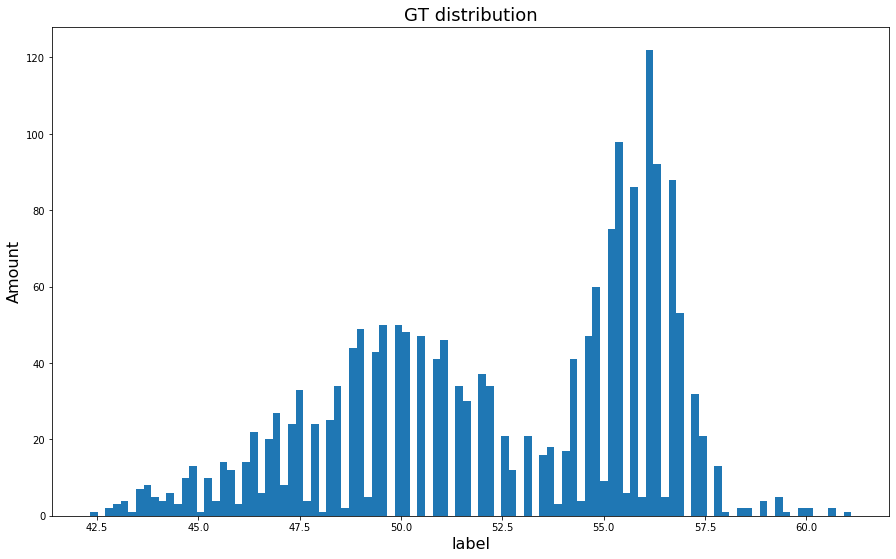

count      mean       std       min       10%       25%       50%  \
abs_diff  1900.0  0.941859  1.042492  0.001282  0.117288  0.321015  0.679485   

               75%      90%      max  
abs_diff  1.224079  1.88448  12.3339

In [22]:
trainval_df = get_sample_results(new_model, trainval)
analyze_sample_results(trainval_df)
torch.cuda.empty_cache()

In [ ]:
trainval_df = get_sample_results(new_model, trainval)
analyze_sample_results(trainval_df)
torch.cuda.empty_cache()

## Find samples of largest error

 Search "label_{label}" in images folder for the actual image

In [23]:
(pd.concat([trainval_df,
           test_df],
          axis=0)
.sort_values('abs_diff', ascending=False).head(10))

pred      label       diff   abs_diff   index
1271  55.836800  43.502899  12.333900  12.333900  1989.0
1558  56.334583  44.669102  11.665482  11.665482   215.0
127   50.046230  60.704100 -10.657870  10.657870   110.0
435   46.724487  56.044701  -9.320213   9.320213  1650.0
814   51.731636  60.120998  -8.389362   8.389362  1107.0
128   52.379723  60.704102  -8.324379   8.324379   121.0
728   55.565662  47.292999   8.272663   8.272663  1738.0
133   49.276897  56.330900  -7.054003   7.054003   320.0
210   48.986099  56.039398  -7.053299   7.053299   211.0
957   50.652481  57.497101  -6.844620   6.844620   387.0

# Display sequences of largest errors


Error of 12.33
Pred: 55.84
3-Sequence of the respective images:
previous call does not exist


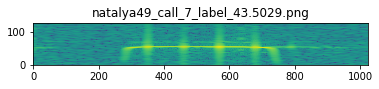


Error of 11.67
Pred: 56.33
3-Sequence of the respective images:


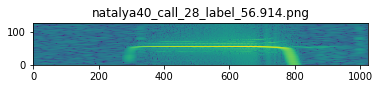

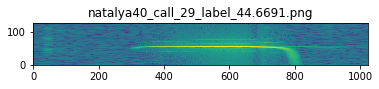

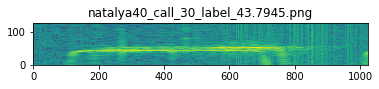


Error of -10.66
Pred: 50.05
3-Sequence of the respective images:


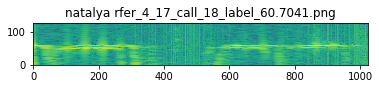

next call does not exist

Error of -9.32
Pred: 46.72
3-Sequence of the respective images:


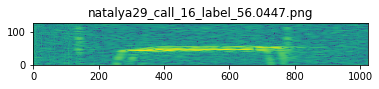

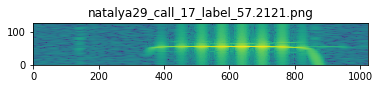


Error of -8.39
Pred: 51.73
3-Sequence of the respective images:
previous call does not exist


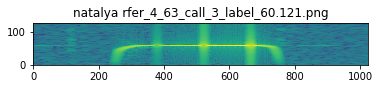

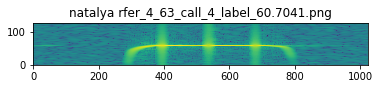


Error of -8.32
Pred: 52.38
3-Sequence of the respective images:


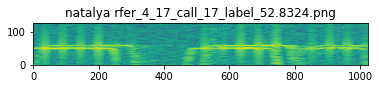

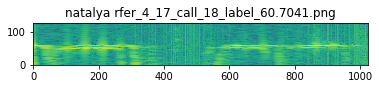

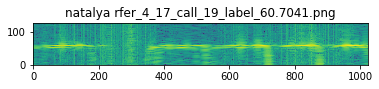


Error of 8.27
Pred: 55.57
3-Sequence of the respective images:


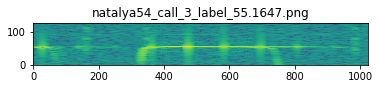

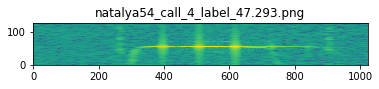

next call does not exist

Error of -7.05
Pred: 49.28
3-Sequence of the respective images:



Error of -7.05
Pred: 48.99
3-Sequence of the respective images:
previous call does not exist


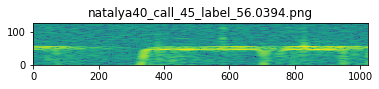


Error of -6.84
Pred: 50.65
3-Sequence of the respective images:


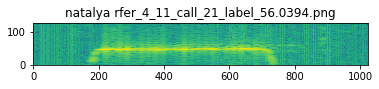

In [24]:
for row in (pd.concat([trainval_df, test_df], axis=0).sort_values('abs_diff', ascending = False).head(10)).iterrows():
    print(f"Error of {row[1]['diff']:.2f}")
    print(f"Pred: {row[1]['pred']:.2f}")
    print("3-Sequence of the respective images:")
    x.seq_from_label(int(row[1]['index']), query_type = 'index')
    print()

# Explain The model behavior

In [25]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2

def rollout(attentions, discard_ratio, head_fusion):
    # print('test')
    result = torch.eye(attentions[0].size(-1))
    with torch.no_grad():
        for attention in attentions:
            if head_fusion == "mean":
                attention_heads_fused = attention.mean(axis=1)
            elif head_fusion == "max":
                attention_heads_fused = attention.max(axis=1)[0]
            elif head_fusion == "min":
                attention_heads_fused = attention.min(axis=1)[0]
            else:
                raise "Attention head fusion type Not supported"

            # Drop the lowest attentions, but
            # don't drop the class token
            flat = attention_heads_fused.view(attention_heads_fused.size(0), -1)
            _, indices = flat.topk(int(flat.size(-1)*discard_ratio), -1, False)
            indices = indices[indices != 0]
            flat[0, indices] = 0

            I = torch.eye(attention_heads_fused.size(-1))
            a = (attention_heads_fused + 1.0*I)/2
            a = a / a.sum(dim=-1)

            result = torch.matmul(a, result)
    
    # Look at the total attention between the class token,
    # and the image patches
    mask = result[0, 0 , 2 :]
    # print(mask.size())
    # In case of 224x224 image, this brings us from 196 to 14
    # width = int(mask.size(-1)**0.5)
    mask = mask.reshape(12, 101).numpy()
    mask = mask / np.max(mask)
    return mask    

class VITAttentionRollout:
    def __init__(self, model, attention_layer_name='attn_drop', head_fusion="mean",
        discard_ratio=0.9):
        self.model = model
        self.head_fusion = head_fusion
        self.discard_ratio = discard_ratio
        for name, module in self.model.named_modules():
            if attention_layer_name in name:
                module.register_forward_hook(self.get_attention)

        self.attentions = []

    def get_attention(self, module, input, output):
        self.attentions.append(output.cpu())

    def __call__(self, input_tensor):
        self.attentions = []
        with torch.no_grad():
            output = self.model(input_tensor)
            print('Prediction=' + str(output.item()))
            # print(output)
            # print(output.size())
            # print(self.attentions[0].size())
            # print(self.discard_ratio)
            # print(self.head_fusion)
        return rollout(self.attentions, self.discard_ratio, self.head_fusion)


def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    img = img
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

GT=56.6224
Prediction=56.545040130615234


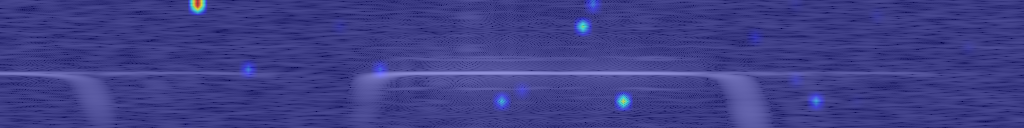

In [26]:
from google.colab.patches import cv2_imshow
# import vit_grad_roll
# from ssast.vit_grad_rollout import VITAttentionGradRollout
# from ssast.vit_rollout import VITAttentionRollout

dataloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
images, labels, index = next(iter(dataloader))
new_model.eval()

query = images.squeeze(1).to(device, dtype=torch.float)

print('GT=' + str(labels.item()))
rollout_vis = VITAttentionRollout(new_model, discard_ratio=0.999, head_fusion='mean')
small_mask = rollout_vis(query)


query_image = query.squeeze().cpu().numpy()
query_image = np.dstack([query_image]*3)

big_mask = cv2.resize(small_mask, (query_image.shape[1], query_image.shape[0]))
masked_image = show_mask_on_image(query_image, big_mask)
cv2_imshow(masked_image)

In [27]:
# Garbage Collector - use it like gc.collect()
import gc
gc.collect()

18958

In [ ]:
# for name in model.named_modules():
#   print (name)

In [15]:
new_model.eval()
dataloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
# model = resnet50(pretrained=True)
# target_layers = [new_model.layer4[-1]]
target_layers = []
for i in range(12):
  target_layers.append(new_model.v.blocks[i].norm1)
# target_layers.append(new_model.v.blocks[-1].norm1)

# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!


def reshape_transform(tensor, height=12, width=101):
    # print(tensor.shape)
    result = tensor[:, 2 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

cam = GradCAM(model=new_model, target_layers=target_layers, reshape_transform=reshape_transform)
targets = [RawScoresOutputTarget()]


# Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.


GT=56.3309
Prediction=56.05139923095703


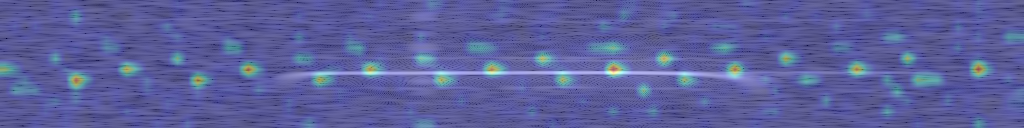

In [26]:
images, labels, index = next(iter(dataloader))
query = images.squeeze(1).to(device, dtype=torch.float)

query_image = query.squeeze().cpu().numpy()
query_image = np.dstack([query_image]*3)/np.max(query_image)

input_tensor = query
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(query_image, grayscale_cam, image_weight = 0.7)

print('GT=' + str(labels.item()))
# output = 
print('Prediction=' + str(new_model(input_tensor).item()))
cv2_imshow(visualization)